## A short tutorial about Rips Update persistence method

This notebook introduces the new feature of our update persistence method. 

Note that this is the most general way in our update scheme, and if the reader only want to change the filtration values on simplices (or permutation of simplices), calling `R.update_filtration(vals2)` , as shown in our Levelset filtration tutorial, might be more efficient. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bats
import time

### Generate Data

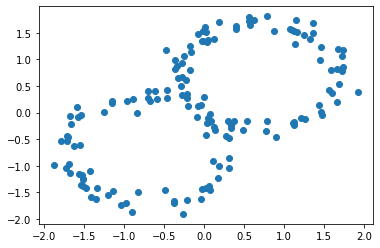

In [2]:
def gen_fig_8(n, r=1.0, sigma=0.1):
    X = np.random.randn(n,2)
    X = r * X / np.linalg.norm(X, axis=1).reshape(-1,1)
    X += sigma*np.random.randn(n, 2) + np.random.choice([-1/np.sqrt(2),1/np.sqrt(2)], size=(n,1))
    return X

np.random.seed(0)
n = 150
X = gen_fig_8(n)

plt.scatter(X[:,0], X[:,1])
plt.show()

### Build Filtration and Perform Reduction

In [3]:
rX = np.inf # largest redistion for Rips Filtration
R0 = bats.LightRipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), rX, 2)
# degree -1 is for homology and +1 for cohomology
degree = 1
DG0 = bats.FilteredF2DGVectorSpace(R0, degree) # chain complex (i.e. (co)boundary matrix)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, 
                                          bats.standard_reduction_flag(), 
                                          bats.clearing_flag(), 
                                          bats.compute_basis_flag()) # reduce (co)boundary matrix

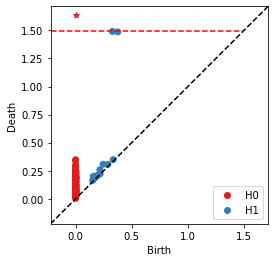

In [4]:
# Plot Persistence Diagram
ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
bats.persistence_diagram(ps0)
plt.show()

### Update Method

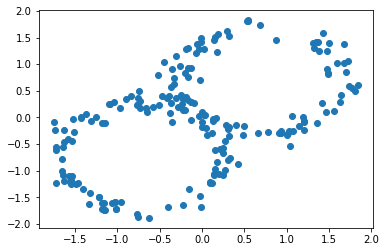

In [5]:
np.random.seed(0)
n = 200
X = gen_fig_8(n)
# add relative noise 
sigma = 1e-3 
X2 = X + X * sigma * np.random.randn(X.shape[0], X.shape[1])

plt.scatter(X2[:,0], X2[:,1])

In [6]:
# We also provide an easy way to compute bottleneck distance
import hera_tda as hera
def bottleneck_dists(RC0, RC1, dmax=1):
    dist = []
    for dim in range(dmax+1):
        ps_a = [p for p in RC0.persistence_pairs(dim) if p.length() > 0]
        ps_b = [p for p in RC1.persistence_pairs(dim) if p.length() > 0]
        dist.append(hera.BottleneckDistance(ps_a, ps_b)[0])
        
    return dist

In [7]:
def find_kt(U): # find Kendall-tau distance
    kts = []
    for p in U.perm:
        kts.append(bats.kendall_tau(p))
    return sum(kts)

def print_UI(U):
    print("kt-dists: ", find_kt(U))
    print("additions: ", sum([len(idxs) for idxs in U.insertion_indices]))
    print("deletions: ", sum(U.ndeletions))

In [8]:
def compare_time(X, Y, rX, rY, degree = -1):
    R0 = bats.LightRipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), rX, 2)
    R1 = bats.LightRipsFiltration(bats.DataSet(bats.Matrix(Y)), bats.Euclidean(), rY, 2)
    
    t0 = time.monotonic()
    DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
    RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), 
                                              bats.clearing_flag(), bats.compute_basis_flag())
    t1 = time.monotonic()
    print("Compute R0: {:.2f} sec.".format(t1 - t0))

    t0 = time.monotonic()
    DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
    RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), 
                                              bats.clearing_flag(), bats.compute_basis_flag())
    t1 = time.monotonic()
    print("Compute R1: {:.2f} sec.".format(t1 - t0))
    print("Bottleneck Distance are", bottleneck_dists(RC0, RC1))
    
    t0 = time.monotonic()
    U = bats.UpdateInfo2(R0, R1)
    t1 = time.monotonic()
    print("Find UpdatInfo: {:.2f} sec.".format(t1 - t0))
    t_info = t1 - t0
    print_UI(U)

    t0 = time.monotonic()
    RC0.update(U)
    t1 = time.monotonic()
    print("Update R0: {:.2f} sec.".format(t_info + t1 - t0))
    
compare_time(X, X2, np.inf, np.inf) # Homology only permutation

Compute R0: 4.98 sec.
Compute R1: 4.89 sec.
Bottleneck Distance are [0.0039815742782507435, 0.004469929559413721]
Find UpdatInfo: 0.31 sec.
kt-dists:  541792892
additions:  0
deletions:  0
Update R0: 0.73 sec.


In [9]:
compare_time(X, X2, 2, 2) # Homology with addition and deletion

Compute R0: 1.64 sec.
Compute R1: 1.65 sec.
Bottleneck Distance are [0.0039815742782507435, 0.004469929559413721]
Find UpdatInfo: 0.11 sec.
kt-dists:  205844182
additions:  581
deletions:  874
Update R0: 0.36 sec.


In [10]:
compare_time(X, X2, 2, 2, +1) # Cohomology with addition and deletion

Compute R0: 0.26 sec.
Compute R1: 0.27 sec.
Bottleneck Distance are [0.0039815742782507435, 0.004469929559413721]
Find UpdatInfo: 0.10 sec.
kt-dists:  205844182
additions:  581
deletions:  874
Update R0: 0.25 sec.


In [11]:
compare_time(X, X2, np.inf, np.inf, +1) # CoHomology only permutation

Compute R0: 0.68 sec.
Compute R1: 0.68 sec.
Bottleneck Distance are [0.0039815742782507435, 0.004469929559413721]
Find UpdatInfo: 0.25 sec.
kt-dists:  541792892
additions:  0
deletions:  0
Update R0: 0.35 sec.


### Final Comment 
The reader can try different max radius of Rips Filtration to see how the size of addition/deletion/permutation(measured K-tau distance) affect on the time spent on updating method.

The takeaway from our experiment is that:
1. Our updating method has a significant improvement for Homology.
2. For Cohomology, our updating method has an improvement on large datasets because finding the updating information sometimes is expensive.
3. The unefficiency in general Cohomology update is because in the step of adding new simplices, we need to compute the new rows in the R matrices instead of just inserting a zero column in the Homology case.